In [126]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
import torch

from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit,train_epoch
import numpy as np
cuda = torch.cuda.is_available()

In [128]:
data_set = pd.read_csv('./data/Diffusion_data.csv')
data_set.columns

Index(['Site2_MeltingT', 'Site1_NdValence', 'Site2_GSestFCClatcnt',
       'AtomicRadii_min_value', 'ElectricalConductivity_min_value',
       'Site2_BCCenergy_pa', 'NdUnfilled_composition_average', 'Row_max_value',
       'SecondIonizationEnergy_max_value', 'NdValence_difference',
       'Site2_Column', 'Site2_NdUnfilled', 'Site2_GSenergy_pa',
       'valence_composition_average', 'Site2_CovalentRadii',
       'ThermalExpansionCoefficient_min_value',
       'HeatFusion_composition_average', 'Site2_HeatFusion',
       'NdUnfilled_max_value', 'n_ws^third_max_value', 'HeatFusion_min_value',
       'IonicRadii_min_value', 'Site2_SpaceGroupNumber', 'Site2_NdValence',
       'Material compositions 1', 'Material compositions 2', 'E_regression',
       'E_regression_shift', 'group'],
      dtype='object')

In [129]:
# data_set = pd.read_csv('./data/friedman_data.csv')


drop_columns = ['E_regression', 'E_regression_shift', 'group',
               'Material compositions 2', 'Material compositions 1']
data_set = data_set.drop(drop_columns, axis = 1)

### Test loader

In [131]:
# Set up data loaders
from datasets import TripletSampling, BatchPairSampling

In [132]:
data_set_shuffled = data_set.sample(frac=1).reset_index(drop=True)
data_set_shuffled.head()

,Site2_MeltingT,Site1_NdValence,Site2_GSestFCClatcnt,AtomicRadii_min_value,ElectricalConductivity_min_value,Site2_BCCenergy_pa,NdUnfilled_composition_average,Row_max_value,SecondIonizationEnergy_max_value,NdValence_difference,...,Site2_CovalentRadii,ThermalExpansionCoefficient_min_value,HeatFusion_composition_average,Site2_HeatFusion,NdUnfilled_max_value,n_ws^third_max_value,HeatFusion_min_value,IonicRadii_min_value,Site2_SpaceGroupNumber,Site2_NdValence
0,2506.0,2.0,4.461398,1.564,2.300000,-9.774649,8.0,6.0,14.925,0.0,...,1.44,5.7,24.100,27.20,8.0,1.45,21.00,0.83,194.0,2.0
1,1687.0,5.0,4.340239,1.320,0.000400,-4.902010,2.5,5.0,16.461,5.0,...,1.11,2.6,43.845,50.21,5.0,1.77,37.48,0.26,227.0,0.0
2,1799.0,0.0,5.058773,1.600,1.800000,-6.340298,4.5,5.0,15.035,0.0,...,1.62,11.3,9.935,11.39,9.0,1.21,8.48,0.72,194.0,1.0
3,1211.4,5.0,4.514685,1.362,0.000003,-4.278365,2.5,5.0,16.461,5.0,...,1.22,4.8,37.210,36.94,5.0,1.77,36.94,0.53,225.0,10.0
4,1811.0,6.0,3.501224,1.241,11.200000,-8.285484,4.0,4.0,16.180,0.0,...,1.17,11.8,13.810,13.81,4.0,1.77,13.81,0.55,229.0,6.0


#### fake grouping for in-domain/ OOD

In [133]:
# fake labels for pos/neg
labels = [1]* int(0.5 * data_set_shuffled.shape[0]) + [0]*int( 0.5 * data_set_shuffled.shape[0] ) 

In [134]:
data_set_shuffled.values

array([[2.50600000e+03, 2.00000000e+00, 4.46139821e+00, ...,
        8.30000000e-01, 1.94000000e+02, 2.00000000e+00],
       [1.68700000e+03, 5.00000000e+00, 4.34023883e+00, ...,
        2.60000000e-01, 2.27000000e+02, 0.00000000e+00],
       [1.79900000e+03, 0.00000000e+00, 5.05877310e+00, ...,
        7.20000000e-01, 1.94000000e+02, 1.00000000e+00],
       ...,
       [1.11500000e+03, 0.00000000e+00, 5.32601427e+00, ...,
        1.00000000e+00, 2.25000000e+02, 0.00000000e+00],
       [2.23700000e+03, 7.00000000e+00, 3.79278409e+00, ...,
        6.30000000e-01, 2.25000000e+02, 8.00000000e+00],
       [2.12800000e+03, 1.00000000e+01, 4.52707952e+00, ...,
        8.40000000e-01, 1.94000000e+02, 2.00000000e+00]])

In [135]:
data_set_shuffled = torch.tensor(data_set_shuffled.values)

In [136]:
#dataloader = TripletSampling( dataset = data_set_shuffled , labels=labels)
datasampler = BatchPairSampling( dataset = data_set_shuffled , labels=labels)
batch_size = 10
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

In [137]:
for batch,_ in train_loader:
    print(len(batch))
    print(batch[0].shape)
    break

2
torch.Size([10, 24])


### Test model

In [138]:
from networks import EmbeddingNet, TripletNet, SiameseNet

In [139]:
input_size = data_set_shuffled.shape[1]
hidden_size = 100
embedding_size = 10
net = EmbeddingNet(input_size, hidden_size, embedding_size)
# triplet_net = TripletNet(  embedding_net = net )
siamese_net = SiameseNet(  embedding_net = net )

In [140]:
x1 = torch.rand( 1,24)
x2 = torch.rand( 1,24)
# x3 = torch.rand( 1,24)
emb1, emb2 = siamese_net(x1,x2)

In [141]:
result = siamese_net(*batch)
print(len(result), len(result[0])) # 2 for pos/neg, 10 for dimension of representation

2 10


### Test loss

In [143]:
from losses import TripletLoss, HardNegativesBatchLoss

def euclidean(a,b):
    if len(a.shape) == 1:
        a = torch.unsqueeze(a,0)
        b = torch.unsqueeze(b,0)
#     print(a)
#     print(b)
    return (a - b).pow(2).sum(1)

margin = 1
distance = euclidean
# loss_fn = TripletLoss( margin = margin, distance = distance)
loss_fn = HardNegativesBatchLoss( margin = margin, distance = distance) 

In [144]:
loss_fn(*result)

tensor(1.1900, grad_fn=<ReluBackward0>)

### Test training

In [146]:
loss_fn = HardNegativesBatchLoss( margin = margin, distance = distance)
lr = 1e-3

hidden_size = 100
embedding_size = 20
net = EmbeddingNet(input_size, hidden_size, embedding_size)
# triplet_net = TripletNet(  embedding_net = net )
siamese_net = SiameseNet(  embedding_net = net )


model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40

datasampler = BatchPairSampling( dataset = data_set_shuffled , labels=labels)
batch_size = 5
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 10

In [147]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/408 (0%)]	Loss: 1.698721
Train: [50/408 (12%)]	Loss: 0.848054
Train: [100/408 (24%)]	Loss: 0.378688
Train: [150/408 (37%)]	Loss: 0.000000
Train: [200/408 (49%)]	Loss: 0.752548
Train: [250/408 (61%)]	Loss: 0.679654
Train: [300/408 (73%)]	Loss: 0.280406
Train: [350/408 (85%)]	Loss: 0.619002
Train: [400/408 (98%)]	Loss: 0.242615
Epoch: 1/40. Train set: Average loss: 0.5113
Train: [0/408 (0%)]	Loss: 0.978723
Train: [50/408 (12%)]	Loss: 0.590187
Train: [100/408 (24%)]	Loss: 0.656042
Train: [150/408 (37%)]	Loss: 0.626364
Train: [200/408 (49%)]	Loss: 0.326682
Train: [250/408 (61%)]	Loss: 0.436401
Train: [300/408 (73%)]	Loss: 0.213953
Train: [350/408 (85%)]	Loss: 1.077647
Train: [400/408 (98%)]	Loss: 0.700702
Epoch: 2/40. Train set: Average loss: 0.5840
Train: [0/408 (0%)]	Loss: 0.293283
Train: [50/408 (12%)]	Loss: 0.699620
Train: [100/408 (24%)]	Loss: 0.273755
Train: [150/408 (37%)]	Loss: 0.575961
Train: [200/408 (49%)]	Loss: 1.021244
Train: [250/408 (61%)]	Loss: 0.841827
Train: [30

Train: [350/408 (85%)]	Loss: 0.272336
Train: [400/408 (98%)]	Loss: 0.312693
Epoch: 22/40. Train set: Average loss: 0.5489
Train: [0/408 (0%)]	Loss: 0.000000
Train: [50/408 (12%)]	Loss: 0.210259
Train: [100/408 (24%)]	Loss: 0.757579
Train: [150/408 (37%)]	Loss: 0.440000
Train: [200/408 (49%)]	Loss: 0.510748
Train: [250/408 (61%)]	Loss: 0.785440
Train: [300/408 (73%)]	Loss: 0.531836
Train: [350/408 (85%)]	Loss: 0.996379
Train: [400/408 (98%)]	Loss: 0.318180
Epoch: 23/40. Train set: Average loss: 0.5581
Train: [0/408 (0%)]	Loss: 0.000000
Train: [50/408 (12%)]	Loss: 0.317711
Train: [100/408 (24%)]	Loss: 0.479000
Train: [150/408 (37%)]	Loss: 0.377639
Train: [200/408 (49%)]	Loss: 0.731181
Train: [250/408 (61%)]	Loss: 0.000670
Train: [300/408 (73%)]	Loss: 0.808607
Train: [350/408 (85%)]	Loss: 0.558786
Train: [400/408 (98%)]	Loss: 0.424383
Epoch: 24/40. Train set: Average loss: 0.4600
Train: [0/408 (0%)]	Loss: 0.000000
Train: [50/408 (12%)]	Loss: 0.617028
Train: [100/408 (24%)]	Loss: 0.493449


In [148]:
def extract_embeddings(dataset, labels, model):
    with torch.no_grad():
        model.eval()
        embeddings = []

        for data in dataset:

            embeddings.append( 
                np.array( 
                    model.get_embedding(data).detach().numpy() ) )

    return np.array(embeddings), labels

In [149]:
embs,labels = extract_embeddings(data_set_shuffled , labels, model)
embs.shape

(408, 20)

In [150]:

from sklearn.manifold import TSNE
# embedded_2 = TSNE(n_components=2, learning_rate='auto',
#      init='random').fit_transform(embs)
tsne = TSNE(n_components=2, perplexity = 5, learning_rate='auto',init='random')
mds = sklearn.manifold.MDS(n_components=2,metric=True, 
                                  n_init=4, 
                                  max_iter=500,
                                  verbose=0, eps=0.001, n_jobs=None, random_state= 1024, dissimilarity='euclidean')


In [151]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    targets = np.array(targets)
    colors = ['r', 'b']
    shapes = ['*', '^']
    for cls in set(targets):
        mask = targets == cls
        cls_emb = embeddings[mask]
        plt.scatter(cls_emb[:,0], cls_emb[:,1], alpha=0.5, marker = shapes[cls],c = colors[cls])

    plt.legend(set(targets))

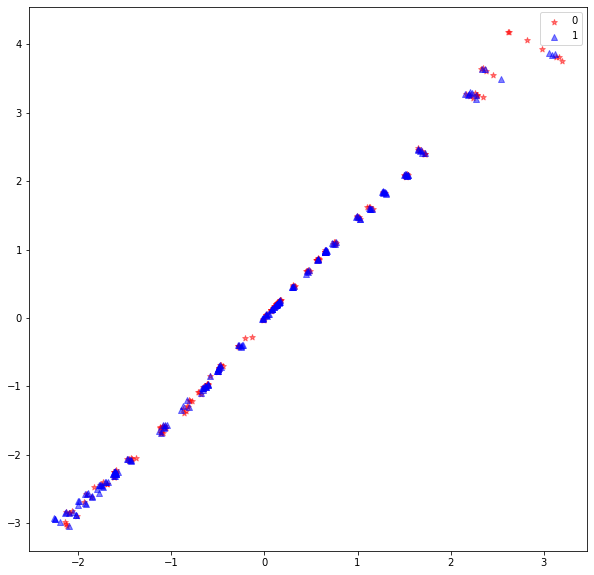

In [152]:
embedded_2_mds = mds.fit_transform(embs)
plot_embeddings(embedded_2_mds, labels)

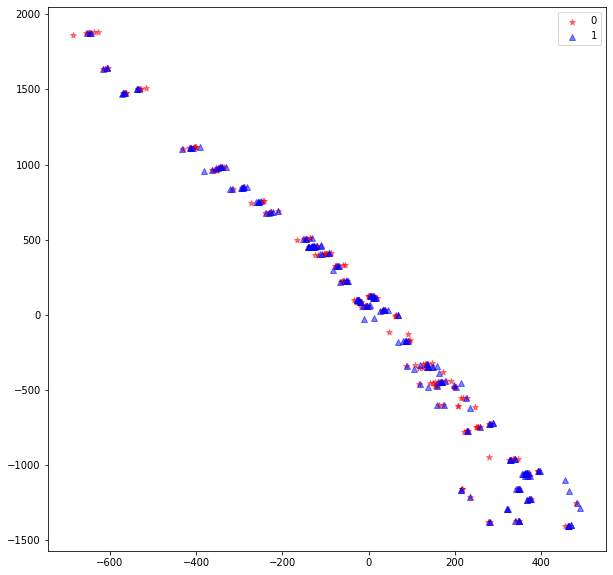

In [153]:
embedded_2_origin_mds = mds.fit_transform(data_set_shuffled)
plot_embeddings(embedded_2_origin_mds, labels)